# Working with Dates & Times

Let's review the data types related to dates & times:

1. **timestamp**: records date & time. Almost always, you'll want to add the keywords `with time zone` to ensure that times stored include time zone information. SQL standard format is `timestamp with time zone`. We can specify time zones in three different formats: UTC offset, area/location designator, or standard abbreviation. If you supply a time without a time zone to a `timestamptz` column, the database will add time zone information using your server's default setting.
2. **date**: records only the date & is part of SQL standard. Valid formats include `September 21, 2022`, or `9/21/2022`, though ISO format, `YYYY-MM-DD`, or `2022-09-21` is recommended.
3. **time**: records only time & is part of SQL standard. Adding `with time zone` makes the column time zone aware, but without a date, the time zone will be meaningless. Given that, using `time with time zone` & its PostgreSQL shortcut `timetz` is strongly discouraged. The ISO format is `HH:MM:SS`, where `HH` represents the hour, `MM` the minutes, & `SS` the seconds.
4. **interval**: holds a value that represents a unit of time expressed in the format `quantity unit`. It doesn't record the start or end of a period, only its duration. Examples include `12 days` or `8 hours`. It's also part of SQL standard, although PostgreSQL-specific syntax offers more options.

The first three data types, `date`, `time`, & `timestamp with time zone` (or `timestamptz`), are known as *datetime types* whose values are called *datetimes*. The `interval` value is an *interval type* whose values are *intervals*. All four data types can track the system clock & the nuances of the calendar. For example, `date` & `timestamp with time zone` recognise that June has 30 days. If we try to use June 31, PostgreSQL will display an error. Likewise, the date February 29 is valid only in a leap year, such as 2024.

---

# Manipulating Dates & Times

We can use SQL functions to perform calculations on dates & times to extract their components. 

## Extracting the Components of a Timestamp Value

It's not unusual to need just one piece of a date or time value for analysis, particularly when you're aggregating results by month, year, or even a minute. We can extract these components using the PostgreSQL `date_part()` function. 

```
date_part(text, value)
```

The function takes two inputs. The first is a string in `text` format that represents the aprt of the date or time to extract, such as `hour`, `minute`, or `week`. The second is the `date`, `time`, `timestamp` value. To see the `date_part()` function in action, we'll execute it multiple times on the same value using the below code.

```
SELECT date_part('year', '2022-12-01 18:37:12 EST'::timestamptz)
           AS year,
       date_part('month', '2022-12-01 18:37:12 EST'::timestamptz)
           AS month,
       date_part('day', '2022-12-01 18:37:12 EST'::timestamptz)
           AS day,
       date_part('hour', '2022-12-01 18:37:12 EST'::timestamptz)
           AS hour,
       date_part('minute', '2022-12-01 18:37:12 EST'::timestamptz)
           AS minute,
       date_part('seconds', '2022-12-01 18:37:12 EST'::timestamptz)
           AS seconds,
       date_part('timezone_hour',
           '2022-12-01 18:37:12 EST'::timestamptz) AS tz,
       date_part('week', '2022-12-01 18:37:12 EST'::timestamptz)
           AS week,
       date_part('quarter', '2022-12-01 18:37:12 EST'::timestamptz)
           AS quarter,
       date_part('epoch', '2022-12-01 18:37:12 EST'::timestamptz)
           AS epoch;
```

Each column statement in this `SELECT` query first uses a string to name the component we want to extract: `year`, `month`, `day`, & so on. The second input uses the string `2022-12-01 18:37:12 EST` cast as a `timestamp with time zone` with the PostgreSQL double-colon syntax & the `timestamptz` shorthand. We specify that this timestamp occurs in the Eastern time zone using the Eastern Standard Time (EST) designation.

Here's the output as shown. The database converts the values to reflect your PostgreSQL time zone setting, so your output might be a bit different; for example, if it's set to the US Pacific time zone, the hour will show as `15`:

<img src = "Extract Components of timestamp Value with date_part().png" width = "600" style = "margin:auto"/>

Each column contains a single component of the timestamp that represents 3:37:12 PM on December 1, 2022. The first six values are easy to recognise from the original timestamp, but the last four deserve an explanation.

In the `tz` column, PostgreSQL reports back the hours difference, or offset from the Coordinated Universal Time (UTC), the time standard for the world. The value of UTC is +/- 00:00, so `-8` specifies a time zone eight hours behind UTC. From November through early March, UTC -8 represents the Pacific time zone. In March, when the Pacific time zone moves to daylight saving time & clocks "spring forward" an hour, its UTC offset changes to -7.

The `week` column shows that December 1, 2022, falls in the 48th week of the year. This number is determined by ISO standards, which start each week on a Monday. A week at the end of a year can extend from December into January of the following year.

The `quarter` column shows that our test date is part of the fourth quarter of the year. The `epoch` column shows a measurement, which is used in computer systems & programming languages, that represents the number of seconds elapsed before or after 12 AM, January 1, 1970 at UTC 0. A positive value designates a time since that point; a negative value designates a time before it. In this example, 1,669,937,832 seconds elapsed between January 1, 1970, & the timestamp. Epoch can be useful for comparing two timestamps mathematically on an absolute scale.

PostgreSQL also supports the SQL-standard `extract()` function, which parses datetimes in the same way as the `date_part()` function. We've featured `date_part()` for two reasons. First, its name helpfully reminds us what it does. Second, `extract()` isn't widely supported by other database managers. Most notably, it's absent in Microsoft's SQL Server. Neverthess, if you need to use `extract()`, the syntax takes this form:

```
extract(text from value)
```

To replicate the first `date_part()` where we pull the year from the timestamp, we'd set up `extract()` like this:

```
extract(year from '2022-12-01 18:37:12 EST'::timestamptz)
```

PostgreSQL provides additional components you can extract or calculate from dates & times. For the full list of functions, see the documentation at [https://www.postgresql.org/docs/current/functions-datetime.html](https://www.postgresql.org/docs/current/functions-datetime.html).

## Creating Datetime Values from timestamp Components

It's not unusual to come across a dataset in which year, month, & day exist in separate columns, & we might want to create a datetime value from these components. To perform calculations on a date, it's helpful to combine & format those pieces correctly into one column.

You can use the following PostgreSQL functions to make datetime objects:

* **make_date(year, month, day)**: returns a value of type `date`.
* **make_time(hour, minute, seconds)**: returns a value of type `time` without time zone.
* **make_timestamptz(year, month, day, hour, minute, second, timezone)**: returns a timestamp with time zone.

The variables for these three functions take `integer` types as input, with two exceptions: seconds are of the type `double precision` because you can supply fractions of seconds, & time zones must be specified with a `text` string that names the time zone.

The below code shows examples of the three functions in action using components of February 22, 2022, for the date, & 6:04:30.3 PM in Lisbon, Portugal for the time.

```
SELECT make_date(2022, 2, 22);

SELECT make_time(18, 4, 30.3);

SELECT make_timestamptz(2022, 2, 22, 18, 4, 30.3,
           'Europe/Lisbon');
```

When we run each query, the output is as follows. Again, yours may be different depending on your PostgreSQL time zone setting:

<img src = "make_date().png" width = "600" style = "margin:auto"/>
<img src = "make_time().png" width = "600" style = "margin:auto"/>
<img src = "make_timestamptz().png" width = "600" style = "margin:auto"/>

Notice that on my computer, the timestamp in the third command shows `10:04:30.3`, which is eight hours behind the time input to the function: `18:04:30.3`. That output is appropriate because Lisbon's time zone is at UTC 0, & my postgreSQL is set to the Pacific time zone, which is UTC-8 in winter months.

## Retrieving the Current Date & Time

If we need to record the current date or time as part of a query -- when updating a row, for example -- standard SQL provides functions for that too. The following functions record the time as of the start of the query:

* **current_timestamp**: returns the current timestamp with time zone. A shorthand Postgre-SQL specific version is `now()`.
* **localtimestamp**: returns the current timestamp without time zone. Avoid using `localtimestamp`, as a timestamp without a time zone can't be placed in a global location & is thus meaningless.
* **current_date**: returns the date.
* **current_time**: returns the current time with time zone. Remember, though, without a date, the time alone with a time zone is useless.
* **locatime**: returns the current time without time zone.

Because these functions record the time at the start of the query (or a collection of queries grouped under a *transaction*), they'll provide that same time throughout the execution of a query regardless of how long the query runs. So, if your query updates 100,000 rows & takes 15 seconds to run, any timestamp recorded at the start of the query will be apaplied to each row, & so each row will receive the same timestamp.

If, instead, you want the date & time to reflect how th clock changes during the execution of the query, you can use the PostgreSQL-specific `clock_timestamp()` function to record the current time as it elapses. That way, if you're updating 100,000 rows & inserting a timestamp each time, each row gets the time the row updated rather than the time at the start of the query. Note that `clock_timestamp()` can slow large queries & may be subject to system limitations.

The below code shows `current_timestamp` & `clock_timestamp()` in action when inserting a row in a table.

```
CREATE TABLE current_time_example (
    time_id integer GENERATED ALWAYS AS IDENTITY,
    current_timestamp_col timestamptz,
    clock_timestamp_col timestamptz
);

INSERT INTO current_time_example (
    current_timestamp_col, clock_timestamp_col
)
(SELECT current_timestamp, clock_timestamp()
 FROM generate_series(1, 1000));

SELECT *
FROM current_time_example;
```

The code creates a table that includes two `timestamptz` columns (the PostgreSQL shorthand for `timestamp with time zone`). The first holds the result of the `current_timestamp` function, which records the time at the start of the `INSERT` statement that adds 1,000 rows to the table. To do that, we use the `generate_series()` function, which returns a set of integers starting with 1 & ending with 1,000. The second column holds the result of the `clock_timestamp()` function, which records the time of insertion of each row. You can call both functions as part of the `INSERT` statement. Run the query, & the result from teh final `SELECT` statement should show that the time in the `current_timestamp_col` is the same for all rows, whereas the time in `clock_timestamp_col` increases with each row inserted.

<img src = "Comparing current_timestamp & clock_timestamp().png" width = "600" style = "margin:auto"/>

---

# Working with Time Zones

Recording a timestamp is useful when we know where on the globe that time occurred -- whether in Asia, Eastern Europe, or one of the 12 time zones of Antartica.

Sometimes, however, datasets contain no time zone data in their datetime columns. This isn't always a deal-breaker in terms of analysing the data. If we know that every event happened in the same location -- for example, readings from a temperature sensor in Bar Harbor, Maine -- we can factor that into our analysis. Better though, during import is to set your session time zone to represent the time zone of the data & load the datetimes into a `timestamptz` column. This strategy helps ward off misinterpretation of the data later.

## Finding Your Time Zone Setting

When working with timestamps that contain time zones, it's important to know your current time zone setting. If you installed PostgreSQL on your own computer, the server's default will be your local time zone. If you're connecting to a PostgreSQL database elsewhere, like on a cloud provider such as AWS, its time zone setting may be different from your own. To help avoid confusion, database administrators often set a shared server's time zone to UTC.

The below code shows two ways to view your current time zone setting: the `SHOW` command with `timezone` keyword & the `current_setting()` function with a `timezone` argument.

```
SHOW timezone;
SELECT current_setting('timezone');
```

Running either statement will display your time zone setting, which will vary according to your operating system & locale. Entering the statements above into pgAdmin returns `America/Los_Angeles`, one of the several location names that falls into the Pacific time zone, which encompasses western Canada, United States, etc.

<img src = "Viewing Your Current Time Zone Setting.png" width = "600" style = "margin:auto"/>

Though both statements provide the same information, you may find `current_setting()` extra handy as an input to another function such as `make_timestamptz()`:

```
SELECT make_timestamptz(2022, 2, 22, 18, 4, 30.3,
           current_setting('time_zone'));
```

The below code shows how to retrieve all the time zone names, abbreviations, & their UTC offsets.

```
SELECT *
FROM pg_timezone_abbrevs
ORDER BY abbrev;

SELECT *
FROM pg_timezone_names
ORDER BY name;
```

You can easily filter either of these `SELECT` statements with a `WHERE` clause to look up specific location names or time zones:

```
SELECT * FROM pg_timezone_names
WHERE name LIKE 'Europe%'
ORDER BY name;
```

This code should return a table listing that includes the time zone name, abbreviation, UTC offset, & a `boolean` column `is_dst` that notes whether the time zone is currently observing daylight saving time:

<img src = "Showing Time Zone Names.png" width = "600" style = "margin:auto"/>

This is a faster way of looking up time zones than using Wikipedia.

## Setting the Time Zone

When you installed PostgreSQL, the server's default time zone was set as a parameter in *postgresql.conf*, a file that contains dozens of values read by PostgreSQL each time it starts. The location of *postgresql.conf* in your file system varies depending on your operating system & sometimes on the way you installed PostgreSQL. To make permanent changes to *postgresql.conf*, such as changing your time zone, you need to edit the file & restart the server, which might be impossible if you're not the owner of the machine. Changes to configurations might also have unintended consequences for other users or applications. Instead, we'll look at setting the time zone on a per-session basis, which should last as long as you're connected to a server. This solution is handy when you want to view a particular table or handle timestamps in a query.

To set the time zone for the current session while using pgAdmin, we use the command `SET TIME ZONE`.

```
SET TIME ZONE 'US/Eastern'

CREATE TABLE time_zone_test (
    test_date timestamptz
);

INSERT INTO time_zone_test
VALUES ('2023-01-01 4:00');

SELECT test_date
FROM time_zone_test;

SET TIME ZONE 'US/Pacific';

SELECT test_date
FROM time_zone_test;

SELECT test_date AT TIME ZONE 'Asia/Seoul'
FROM time_zone_test;
```

First, we set the time zone to `US/Eastern`, which designates the Pacific time zone. The syntax `SET TIME ZONE` is part of the ANSI SQL standard. PostgreSQL also supports the nonstandard syntax `SET timezone TO`.

Second, we create a one-column table with a data type of `timestamptz` & insert a single row to display a test result. Notice that the value inserted, `2023-01-01 4:00`, is a timestamp with no time zone. You'll encounter timestamps with no time zone often, particularly when you acquire datasets restricted to a specific location.

When executed, the first `SELECT` statement returns `2023-01-01 4:00` as a timestamp that now contains time zone data:

<img src = "Setting the Time Zone for a Client Session 1.png" width = "600" style = "margin:auto"/>

Here, the `-05` shows that the Eastern time zone is five hours behind UTC in January, when standard time is in effect. Because we set the pgAdmin client's time zone to `US/Eastern` for this session, any value without a time zone entered into a column that is time zone-aware will be set to Eastern time. if we entered a date that falls during daylight saving time, the UTC offset would be `-04`.

Now we change the time zone for this session to the Pacific Time ZOne using the `SET` command & the `US/Pacific` designation. Then, when we execute the `SELECT` statement again, the result should be as follows:

<img src = "Setting the Time Zone for a Client Session 2.png" width = "600" style = "margin:auto"/>

In this example, two components of the timestamp have changed: the time is now `1:00`, & the UTC offset is `-08` because we're viewingthe timestamp from the perspective of the Eastern time zone: 1 AM Pacific is 4 AM Eastern. The database converts the original Eastern time value to the Pacific time zone.

Even more convenient is that we can view a timestamp through the lens of any time zone without changing the session setting. The final `SELECT` statement using the `AT TIME ZONE` keywords to display the timestamp in our session as the Korea standard time (KST) zone by specifying `Asia/Seoul`:

<img src = "Setting the Time Zone for a Client Session 3.png" width = "600" style = "margin:auto"/>

Now we know that the value of 1 AM in `US/Pacific` on January 1, 2023, is equivalent to 6 PM that same day in `Asia/Seoul`. Again, this syntax changes the output data, but the data on the server remains unchanged. When using the `AT TIME ZONE` keywords, also note this quirk: if the original value is a `timestamptz`, the output is a `timestamp` with no time zone. If the original value has no time zone, the output is `timestamptz`.

---

# Performing Calculations with Dates & Times

We can perform simple arithmetic on datetime & interval types the same way we can on numbers. Addition, subtraction, multiplication, & division are all possible in PostgreSQL using the math operators `+`, `-`, `*`, & `/`. For example, you can subtract one date from another date to get an integer that represents the difference in days between the two dates. The following code returns an integer of `3`:

```
SELECT '1929-09-30'::date - '1929-09-27'::date;
```

The result indicates that these two dates are exactly three days apart.

Likewise, you can use the following code to add a time interval to a date to return a new date:

```
SELECT '1929-09-30'::date + '5 years'::interval;
```

This code adds five years to the `1929-09-30` to return a timestamp value of `1934-09-30`.

More examples of math functions you can use with dates & times are available in the PostgreSQL documentation at [https://www.postgresql.org/docs/current/functions-datetime.html](https://www.postgresql.org/docs/current/functions-datetime.html).

## Finding Patterns in New York City Taxi Data

The *nyc_yellow_taxi_trips.csv* file available from the course's resources holds one day of yellow taxi trip records from June 1, 2016. Build a `nyc_yellow_taxi_trips` table. 

```
CREATE TABLE nyc_yellow_taxi_trips (
    trip_id bigint GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
    vendor_id text NOT NULL,
    tpep_pickup_datetime timestamptz NOT NULL,
    tpep_dropoff_datetime timestamptz NOT NULL,
    passenger_count integer NOT NULL,
    trip_distance numeric(8,2) NOT NULL,
    pickup_longitude numeric(18,15) NOT NULL,
    pickup_latitude numeric(18,15) NOT NULL,
    rate_code_id text NOT NULL,
    store_and_fwd_flag text NOT NULL,
    dropoff_longitude numeric(18,15) NOT NULL,
    dropoff_latitude numeric(18,15) NOT NULL,
    payment_type text NOT NULL,
    fare_amount numeric(9,2) NOT NULL,
    extra numeric(9,2) NOT NULL,
    mta_tax numeric(5,2) NOT NULL,
    tip_amount numeric(9,2) NOT NULL,
    tolls_amount numeric(9,2) NOT NULL,
    improvement_surcharge numeric(9,2) NOT NULL,
    total_amount numeric(9,2) NOT NULL);

COPY nyc_yellow_taxi_trips (
    vendor_id,
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    passenger_count,
    trip_distance,
    pickup_longitude,
    pickup_latitude,
    rate_code_id,
    store_and_fwd_flag,
    dropoff_longitude,
    dropoff_latitude,
    payment_type,
    fare_amount,
    extra,
    mta_tax,
    tip_amount,
    tolls_amount,
    improvement_surcharge,
    total_amount
)
FROM '/YourDirectory/nyc_yellow_taxi_trips.csv'
WITH (FORMAT CSV, HEADER);

CREATE INDEX tpep_pickup_idx
ON nyc_yellow_taxi_trips (tpep_pickup_datetime);
```

The code builds the table, imports the rows, & creates an index. In the `COPY` statement, we provide the names of columns because the input CSV file doesn't include the `trip_id` column that exists in the target table. That column is of type `bigint` & set as an auto-incrementing surrogate primary key. After your import is complete, you should have 368,774 rows, one for each yellow cab ride on June 1, 2016. You can count the rows in your table using the following code:

```
SELECT count(*) FROM nyc_yellow_taxi_trips;
```

<img src = "Creating a Table & Importing NYC Yellow Taxi Data.png" width = "600" style = "margin:auto"/>

Each row includes data on the number of passengers, the location of pickup & drop-off in latitude & longitude, & the fare & tips in US dollars. We're most interested in the timestamp columns `tpep_pickup_datetime` & `tpep_dropoff_datetime`, which represent the start & end times of the ride. 

The values in both timestamp columns include the time zone: `-4`. That's the UTC offset for the Eastern time zone during summer, when daylight saving time is observed.

```
SET TIME ZONE 'US/Eastern';
```

### The Busiest Time of Day

One question you might wonder is when taxis provide the most rides. Is it morning or evening rush hour, or is there another time when ridership strikes? You can find the answer with a simple aggregation query that uses `date_part()`.

The below code contains the query to count rides by hour using the pickup time as the input.

```
SELECT date_part('hour', tpep_pickup_datetime)
           AS trip_hour,
       count(*)
FROM nyc_yellow_taxi_trips
GROUP BY trip_hour
ORDER BY trip_hour;
```

In the query's first column, `date_part()` extracts the hour from `tpep_pickup_datetime` so we can group the number of rides by hour. Then we aggregate the number of rides in the second column via the `count()` function. The rest of the query follows the standard patterns for grouping & ordering the results, which should return 24 rows, one for each hour of the day:

<img src = "Counting Taxi Trips by Hour.png" width = "600" style = "margin:auto"/>


Eyeballing the numbers, it's apparent that on June 1, 2016, New York taxis had the most passengers between 6PM & 10PM, possibly reflecting commutes home plus the plethora of city activities on a summer evening. But to see the overall pattern, it's best to visualise the data.

### Exporting to CSV for Visualisation

We'll make a chart to show the patterns.

```
COPY (SELECT date_part('hour',
          	 	 tpep_pickup_datetime) AS trip_hour,
		  	 count(*)
      FROM nyc_yellow_taxi_trips
      GROUP BY trip_hour
      ORDER BY trip_hour)
TO '/YourDirectory/hourly_taxi_pickups.csv'
WITH (FORMAT CSV, HEADER);
```

In [3]:
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt

hourly_taxis = pd.read_csv("hourly_taxi_pickups.csv")
hourly_taxis

,trip_hour,count
0,0,8182
1,1,5003
2,2,3070
3,3,2275
4,4,2229
5,5,3925
6,6,10825
7,7,18287
8,8,21062
9,9,18975


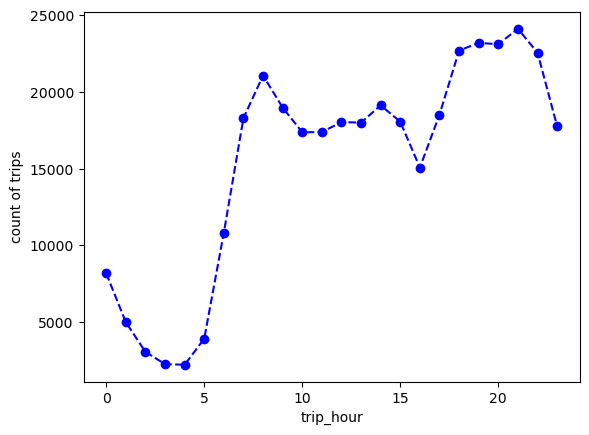

In [6]:
plt.plot(hourly_taxis["trip_hour"], hourly_taxis["count"], 
         "--bo")
plt.xlabel("trip_hour")
plt.ylabel("count of trips")
plt.show()

Rides bottom out in the wee hours of the morning before rising sharply between 5 AM & 8 AM. Volume remained relatively steady throughout the day & increase again for evening rush hour after 5 pm. But there was a dip between 3 PM & 4PM -- why?

To answer that question, we need to dig deeper to analyse data that spanned several days or even several months to see whether our data from June 1, 2016 is atypical. We could use the `date_part()` function to compare trip volume on weekdays versus weekends by extracting the day of the week. To be even more ambitious, we could check weather reports & compare trips on rainy days versus sunny days. You can slice data in many ways to reach concolusions

### When Do Trips Take the Longest?

Let's investigate another interesting question: at which hour did taxi trips take the longest? One way to find an answer is to calculate the median trip time for each hour. The median is the middle value in an ordered set of values; it's often more accurate than an average for making comparisons because a few very small or very large values in the set won't skey the results as they would with an average.

We'll use the `percentile_cont()` function to find medians. We'll use it to calculate median trip times.

```
SELECT date_part('hour',
           tpep_pickup_datetime) AS trip_hour,
       percentile_cont(0.5) WITHIN GROUP (ORDER BY
           tpep_dropoff_datetime - tpep_pickup_datetime)
           AS median_trip
FROM nyc_yellow_taxi_trips
GROUP BY trip_hour
ORDER BY trip_hour;
```

We're aggregating data by the hour portion of the timestamp column `tpep_pickup_datetime` again, which we extract using `date_part()`. For the input to the `percentile_cont()` function, we subtract the pickup time from the drop-off time in the `WITHIN GROUP` clause. The results show that the 1PM hour has the highest median trip time of 15 minutes:

<img src = "Calculating Median Trip Time by Hour.png" width = "600" style = "margin:auto"/>

As we would expect, trip times are shortest in the early morning. This makes sense because less traffic early in the day means passengers are more likely to get to their destinations faster.

## Finding Patterns in Amtrak Data

Amtrak, the nationwide rail service in American, offers several packaged trips across the United States. Using data from the Amtrack, we'll build a table with information about each segment of the trip. The trip spans four time zones, so we'll track the time zone with each arrival & departure. Then, we'll calculate the duration of the journey at each segment & figure out the length of the entire trip.

### Calculating the Duration of Train Trips

Let's create a table that tracks the six segments of the Amtrak route.

```
CREATE TABLE train_rides (
    trip_id bigint GENERATED ALWAYS AS IDENTITY
        PRIMARY KEY,
    segment text NOT NULL,
    departure timestamptz NOT NULL,
    arrival timestamptz NOT NULL
);

INSERT INTO train_rides (segment, departure, arrival)
VALUES ('Chicago to New Yok', '2020-11-13 21:30 CST',
        '2020-11-14 18:23 EST'),
       ('New York to New Orleans', '2020-11-15 14:15 EST',
        '2020-11-16 19:32 CST'),
       ('New Orleans to Los Angeles', '2020-11-17 13:45 CST',
        '2020-11-18 9:00 PST'),
       ('Los Angeles to San Francisco', '2020-11-19 10:10 PST',
        '2020-11-19 21:24 PST'),
       ('San Francisco to Denver', '2020-11-20 9:10 PST',
        '2020-11-21 18:38 MST'),
       ('Denver to Chicago', '2020-11-22 19:10 MST',
        '2020-11-23 14:50 CST');

SET TIME ZONE 'US/Central';

SELECT * FROM train_rides;
```

First, we set the standard `CREATE TABLE` statement. Note that columns for departure & arrival times are set to `timestamptz`. Next, we insert rows that represent the six legs of the trip. Each timestamp input reflects the time zone of the city of departure or arrival. Specifying the city's time zone is the key to getting an accurate calculation of trip duration & accounting for time zone changes. It also accounts for annual changes to & from daylight saving time if they were to occure during the time span you're examinating.

Next, we set the session to the Central time zone, the value for Chicago, using the `US/Central` designator. We'll use Central time as our reference when viewing the timestamps so that regardless of timezones, we share the same view of the data.

The final `SELECT` statement should return the contents ofthe table like this:

<img src = "Creating a Table to Hold Trip Data.png" width = "600" style = "margin:auto"/>

All timestamps should now carry a UTC offset of `-06`, reflecting the Central time zone in the United States during November, when standard time is in effect. All time values display in their Central time equivalents.

Note that we've created segments corresponding to each leg of the trip, we'll use it to calculate the duration of each segment.

```
SELECT segment,
       to_char(departure, 'YYYY-MM-DD HH12:MI a.m. TZ')
           AS departure,
       arrival - departure AS segment_duration
FROM train_rides;
```

This query lists the trip segment, the departure time, & the duration of the segment journey. Before we look at the calculation, notice the additional code around the `departure`column. These are PostgreSQL-specific formatting functions that specify how to format different components of the timestamp. In this case, the `to_char()` function turns the `departure` timestamp column into a string of characters formatted as `YYYY-MM-DD HH12:MI a.m. TZ`. The `YYYY-MM-DD` portion of the ISO format for the date, & the `HH12:MI a.m.` portion presents the time in hours & minutes. The `HH12` portion specifies the use of a 12-hour clock rather than 24-hour military time. The `a.m.` portion specifies that we want to show morning or night times using lowercase characters separated by periods, & the `TZ` portion denotes the time zone.

For a complete list of formatting functions, check out the [PostgreSQL documentation](https://www.postgresql.org/docs/current/functions-formatting.html).

Last, we subtract `departure` from `arrival` to determine the `segment_duration`. When we run the query, the output should look like this:

<img src = "Calculating Length of each Trip Segment.png" width = "600" style = "margin:auto"/>

Subtracting one timestamp from another produces an `interval` data type. As long as the value is less than 25 hours, PostgreSQL presents the interval in the `HH:MM:SS` format. For values greater than 24 hours, it returns the format `1 day 08:28:00`, as shown in the San Francisco to Denver segment.

In each calculation, PostgreSQL accounts for the changes in time zones, so we don't inadvertently add or lose hours when subtracting. If we use a `timestamptz` data type, we would end up with an incorrect trip length if a segment spanned multiple time zones.

### Calculating Cumulative Trip Time

As it turns out, San Francisco to Denver is the longest leg of the AmTrack train trip. But how long does the entire trip take?

Our prior query produced an interval, which we labeled `segment_duration`. The next natural next step would be to write a query to add those values, creating a cumulative interval after each segment. Indeed, we can use `sum()` as a window function, combined with the `OVER` clause to create running totals. But when we do, the results are a bit odd.

```
SELECT segment,
       arrival - departure AS segment_duration,
       sum(arrival - departure) OVER (ORDER BY
           trip_id) AS cumul_duration
FROM train_rides;
```

In the third column, we sum the intervals generated when we subtract `departure` from `arrival`. The resulting running total in the `cumul_duration` column is accurate but formated in an unhelpful way:

<img src = "Calculating Cumulative Intervals Using OVER.png" width = "600" style = "margin:auto"/>

PostgreSQL creates one sum for the day portion of the interval & another for the hours & minutes. So, instead of a more understandable cumulative time of `5 days 13:47:00`, the database reports `2 days 85:47:00`. Both results amount to the same length of time, but `2 days 85:47:00` is harder to decipher. This is an unfortunate limitation of summing the database intervals using this syntax.

To get around the limitation, we'll wrap the window function calculation for the cumulative duration inside the `justify_interval()` function.

```
SELECT segment,
       arrival - departure AS segment_duration,
       justify_interval(sum(arrival - departure)
           OVER (ORDER BY trip_id)) AS cumul_duration
FROM train_rides;
```

The `justify_interval()` function standardises output of interval calculations so that groups of 24 hours are rolled up to days, & groups of 30 days are rolled up to months. So, instead of returning a cumulative duration of `2 days 85:47:00`, `justify_interval()` converts 72 of those 85 hours to three days & adds them to the `days` value. The output is easier to understand.

<img src = "Using justify_interval() to Better Format Cumulative Trip Duration.png" width = "600" style = "margin:auto"/>

The final `cumul_duration` adds all the segments & returns the total trip duration of `5 days 13:47:00`.

---

# Wrapping Up

Handling times & dates in SQL database adds an intriguing dimension to analysis. With a solid grasp of time & date formats, time zones, & functions to dissect the components of a timestamp, we can analyse just about any dataset we come across.